In [275]:
import gym

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from collections import namedtuple
import random
import matplotlib.pyplot as plt
import copy
import time

In [276]:
ENV_NAME = 'Pendulum-v0'
env = gym.make(ENV_NAME)
TAU = .01
GAMMA = .9
LR_actor = .001
LR_critic = .001
EXPERIENCE_CAPACITY = 7000
TARGET_UPDATE_FREQUENCY = 200
MAX_EPI = 200
MAX_STEP = 400
BATCH_SIZE = 32
#EPSILON = .1
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.shape[0]

[2017-08-10 18:31:51,776] Making new env: Pendulum-v0


In [277]:
# initialization
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

In [278]:
# classes
class Experience(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.mem = []
        self.pos = 0
    
    def push(self, o, a, r, o_next):
        if len(self.mem) < self.capacity:
            self.mem.append(None)
        self.mem[self.pos] = Transition(o, a, r, o_next)
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, size):
        return random.sample(self.mem, min(size, len(self.mem)))
        #return self.mem[:min(size, len(self.mem))]
    
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fcS = nn.Linear(N_STATES, 50)
        self.fcS.weight.data.normal_(0, 0.1)
        self.fcA = nn.Linear(N_ACTIONS, 50)
        self.fcA.weight.data.normal_(0, 0.1)
        self.fc1 = nn.Linear(50, 50)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(50, 1)
        self.fc2.weight.data.normal_(0, 0.1)
    
    def forward(self, x, y):
        s = self.fcS(x)
        a = self.fcA(y)
        o = F.relu(s+a)
        o = self.fc1(o)
        o = F.relu(o)
        o = self.fc2(o)
        return o

class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(50, 50)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(50, N_ACTIONS)
        self.fc3.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [279]:
def choose_action(state, actor):
    a = actor(Variable(Tensor(state).unsqueeze(0))).data.cpu().numpy()[0].astype('float64')
    return a

def update_actor_critic(target_actor, target_critic, \
                       actor, critic, exp, optim_actor, optim_critic):
    # sample minibatch
    minibatch = Transition(*zip(*exp.sample(BATCH_SIZE)))
    bat_o = Variable(Tensor(minibatch.state))
    bat_a = Variable(Tensor(minibatch.action))
    bat_r = Variable(Tensor(minibatch.reward)).unsqueeze(1)
    bat_o_ = Variable(Tensor(minibatch.next_state))
    
    Gt = bat_r + GAMMA * target_critic(bat_o_, target_actor(bat_o_))
    Gt.detach_()
    eval_o = critic(bat_o, bat_a)
    criterion = nn.MSELoss()
    if use_cuda:
        criterion.cuda()
    loss = criterion(eval_o, Gt)
    #optimizer = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_critic.zero_grad()
    loss.backward()
    optim_critic.step()
    
    # update actor
    obj = torch.mean(critic(bat_o, actor(bat_o)))
    #optimizer = optim.Adam(actor.parameters(), lr=-LR_actor)
    optim_actor.zero_grad()
    obj.backward()
    optim_actor.step()

def update_target(target_actor, target_critic, \
                         actor, critic):
    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())

def soft_update(target, behavior, tau):
    for key in target.state_dict().keys():
        target.state_dict()[key].copy_(tau * behavior.state_dict()[key] + (1-tau) * target.state_dict()[key])

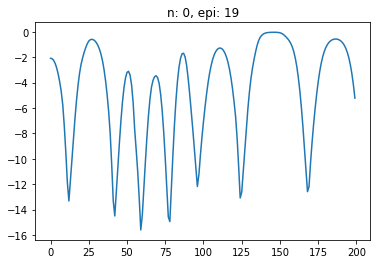

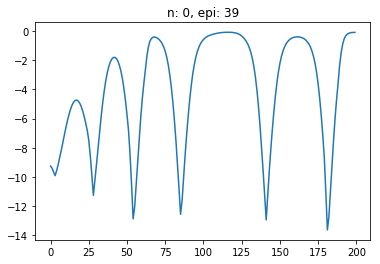

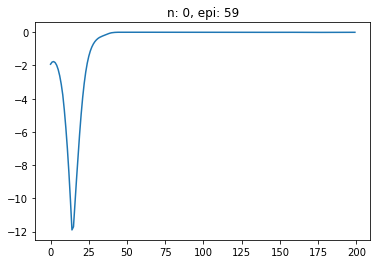

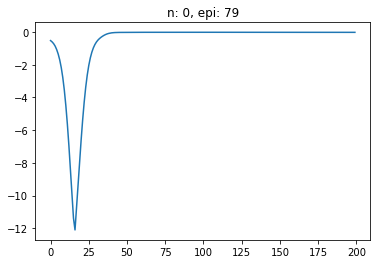

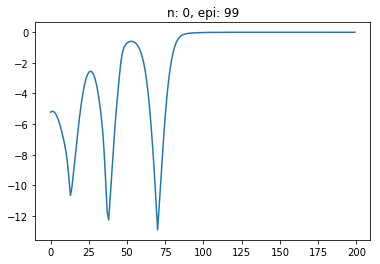

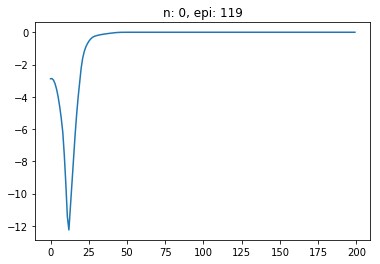

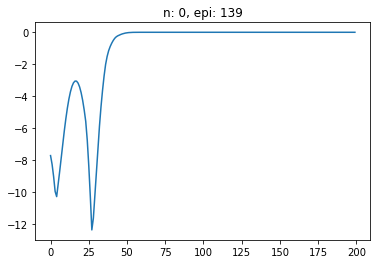

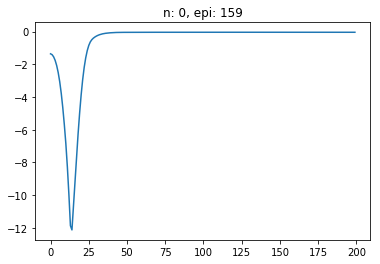

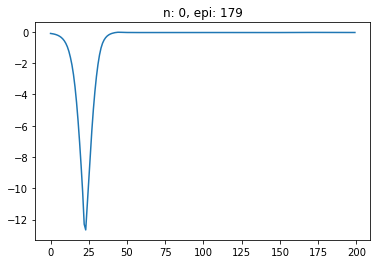

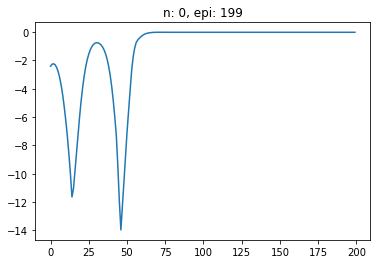

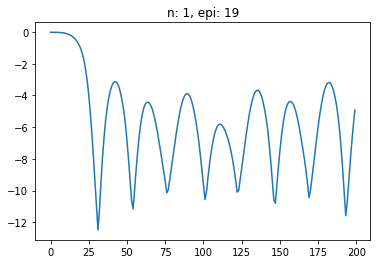

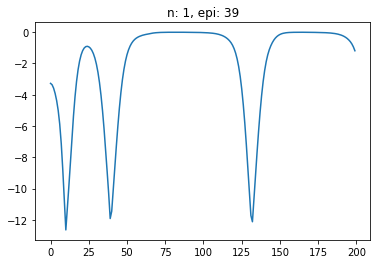

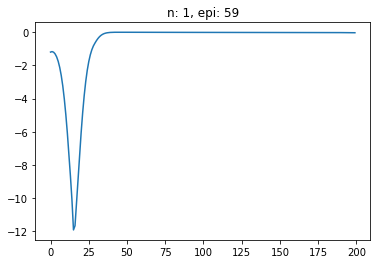

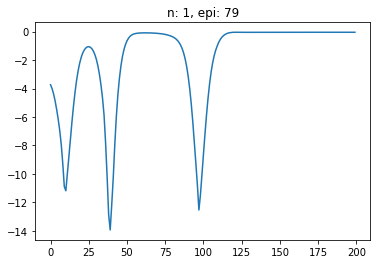

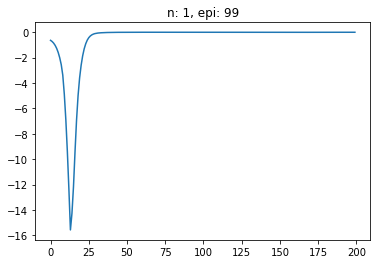

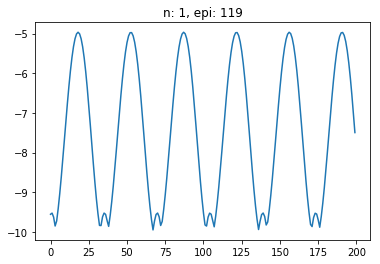

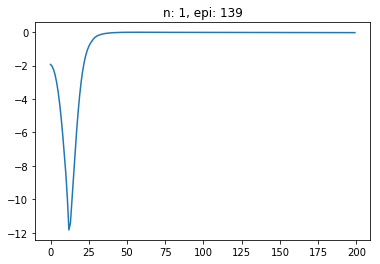

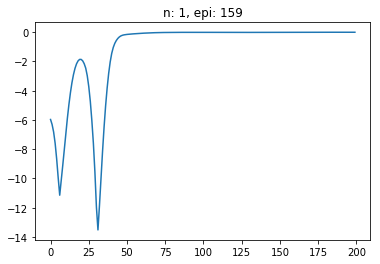

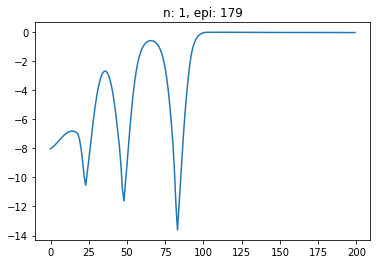

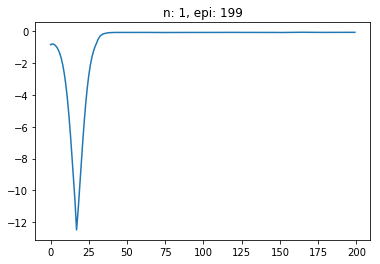

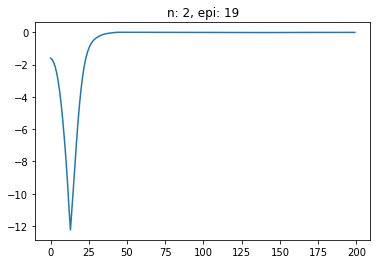

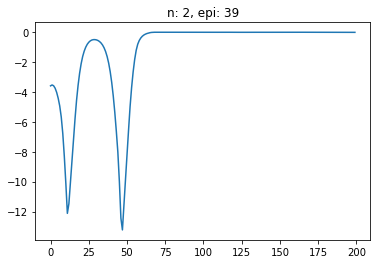

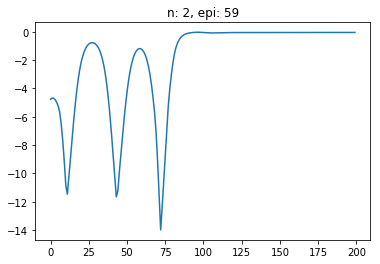

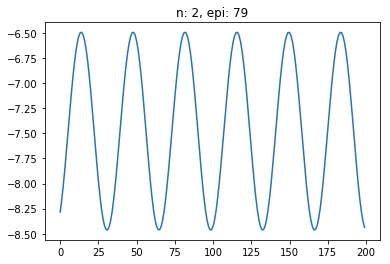

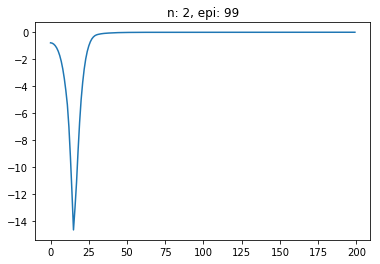

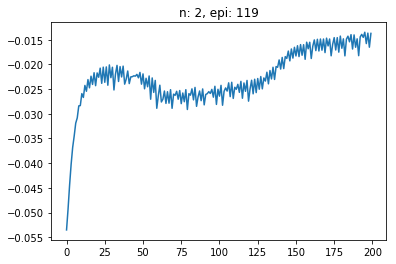

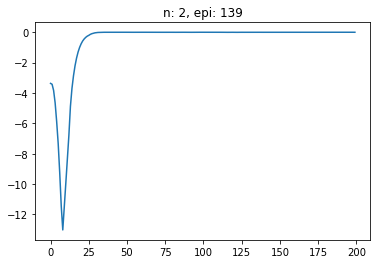

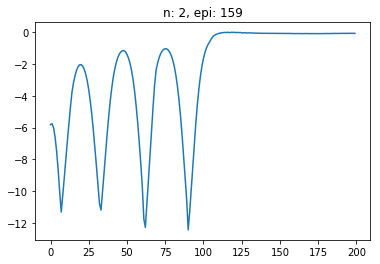

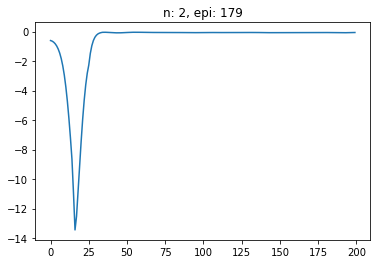

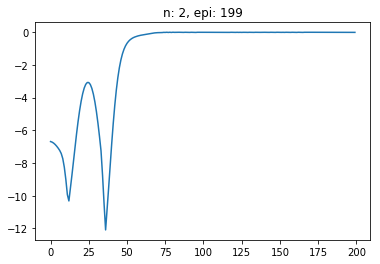

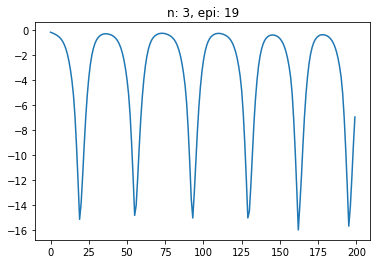

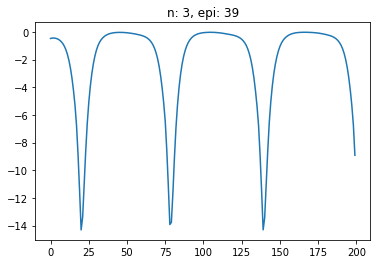

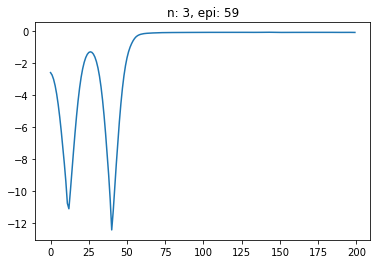

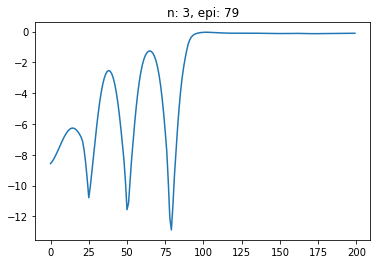

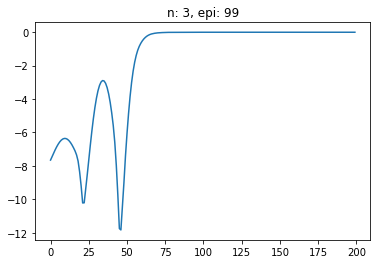

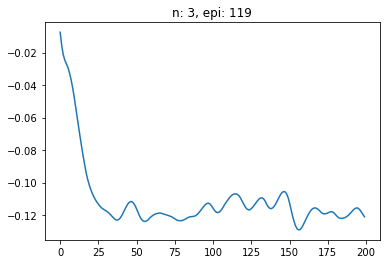

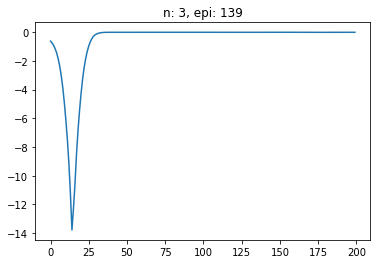

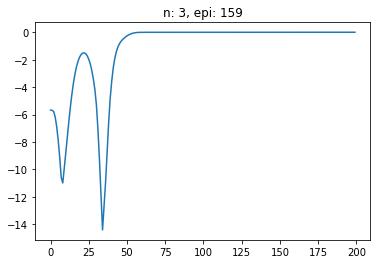

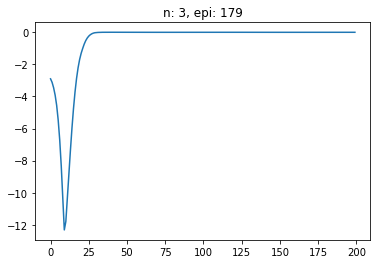

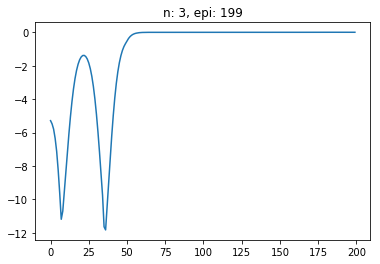

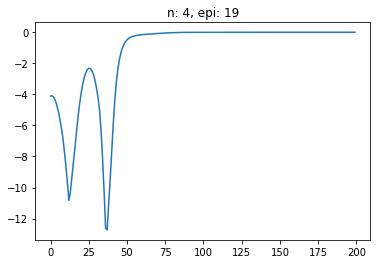

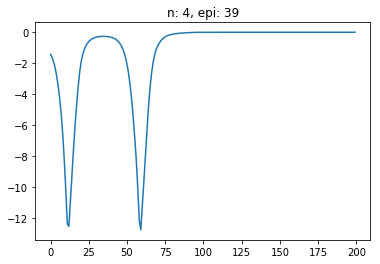

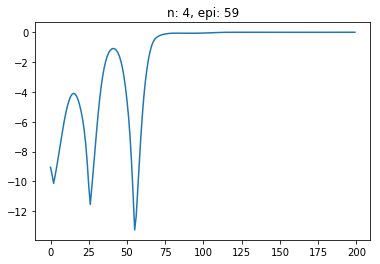

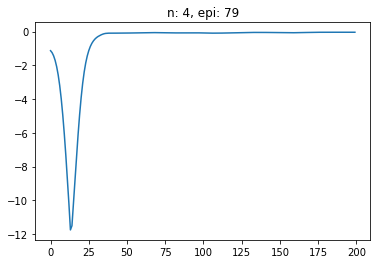

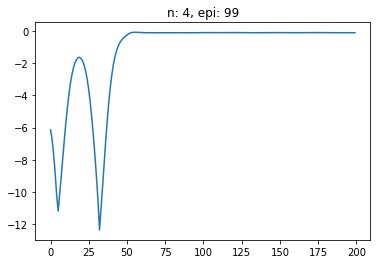

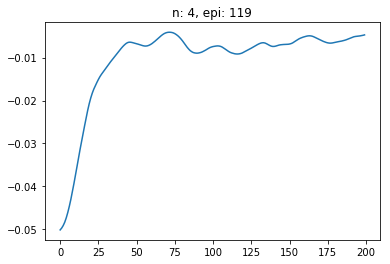

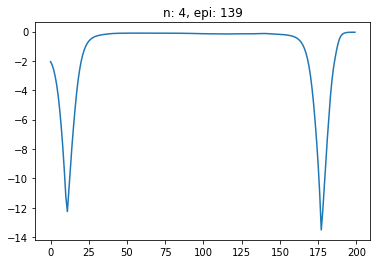

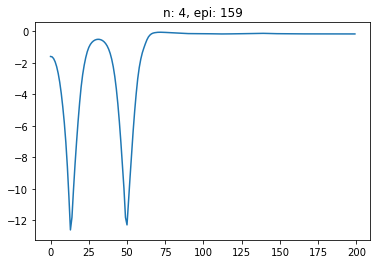

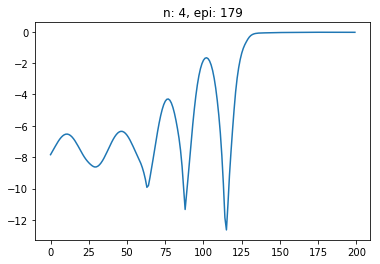

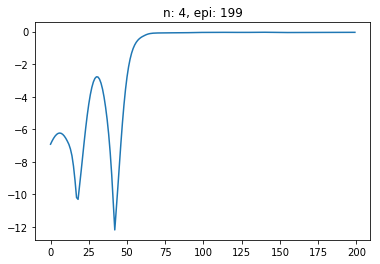

--- 727.068831205 seconds ---


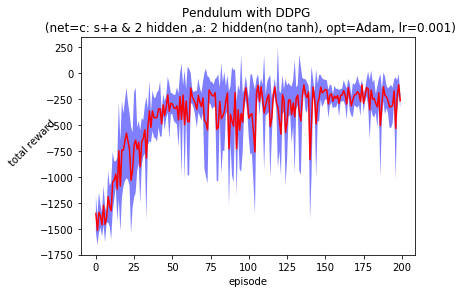

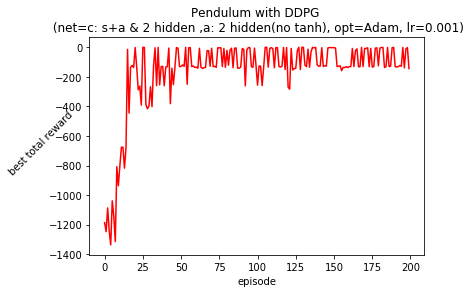

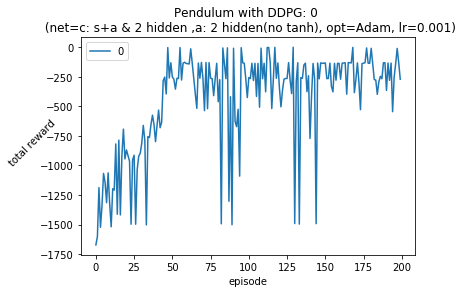

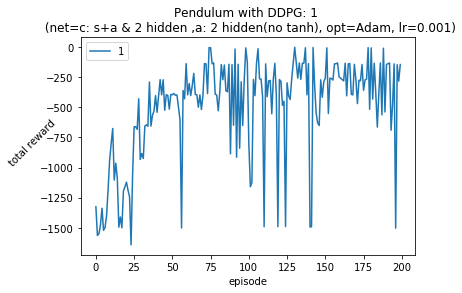

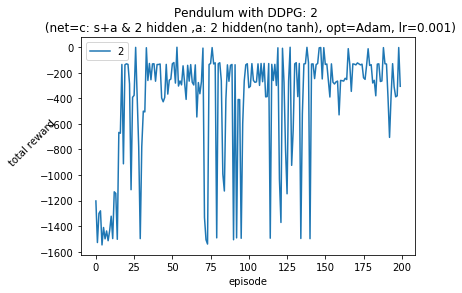

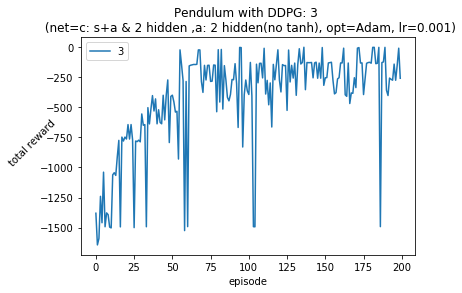

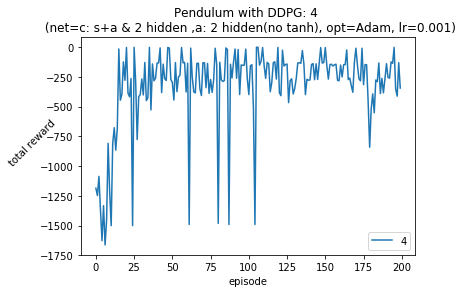

In [280]:
start_time = time.time()

n_vec_r = []
for n in xrange(5):    
    target_actor = Actor()
    target_critic = Critic()
    actor = Actor()
    critic = Critic()
    if use_cuda:
        target_actor.cuda()
        target_critic.cuda()
        actor.cuda()
        critic.cuda()
    exp = Experience(EXPERIENCE_CAPACITY)
    optim_critic = optim.Adam(critic.parameters(), lr=LR_critic)
    optim_actor = optim.Adam(actor.parameters(), lr=-LR_actor)

    target_actor.load_state_dict(actor.state_dict())
    target_critic.load_state_dict(critic.state_dict())
    
    vec_r = []
    update_counter = 0
    for epi in xrange(MAX_EPI):
        o = env.reset()
        acc_r = 0
        
        local_r = []
        
        for t in xrange(MAX_STEP):    
            a = choose_action(o, actor)
            
            o_, r, done, info = env.step(a)
            exp.push(o, a, r, o_)
            
            update_actor_critic(target_actor, target_critic, \
                               actor, critic, exp, optim_actor, optim_critic)
            update_counter += 1
            
            if update_counter % TARGET_UPDATE_FREQUENCY == 0:
                update_target(target_actor, target_critic, \
                             actor, critic)
            
            local_r.append(r)
            acc_r += r
            o = o_
            if done:
                break

        if epi % (MAX_EPI/10) == (MAX_EPI/10)-1:
            plt.plot(xrange(len(local_r)), local_r)
            plt.title('n: {}, epi: {}'.format(n, epi))
            plt.show()

        vec_r.append(acc_r)
    n_vec_r.append(vec_r)

print("--- %s seconds ---" % (time.time() - start_time))

record = np.array(n_vec_r)
mu = record.mean(axis=0)
sigma = record.std(axis=0)
lower_bound = mu-sigma
upper_bound = mu+sigma

str_training_method = type(optim_critic).__name__
str_network_structure = 'c: s+a & 2 hidden ,a: 2 hidden(no tanh)'
str_learning_rate = LR_actor

plt.plot(xrange(len(mu)), mu, color='red')
plt.fill_between(xrange(len(mu)), lower_bound, upper_bound, facecolor='blue', alpha=0.5)
plt.title('Pendulum with DDPG \n (net={}, opt={}, lr={})'.format(str_network_structure, str_training_method, str_learning_rate))
plt.xlabel('episode')
plt.ylabel('total reward', rotation=45)
plt.savefig('net={}_opt={}_lr={}_summary.png'.format(str_network_structure, str_training_method, str_learning_rate))
plt.show()

best = record.max(0)
plt.plot(xrange(len(best)), best, color='red')
plt.title('Pendulum with DDPG \n (net={}, opt={}, lr={})'.format(str_network_structure, str_training_method, str_learning_rate))
plt.xlabel('episode')
plt.ylabel('best total reward', rotation=45)
plt.savefig('net={}_opt={}_lr={}_max.png'.format(str_network_structure, str_training_method, str_learning_rate))
plt.show()


for i, vec in enumerate(n_vec_r):
    plt.plot(xrange(len(vec)), vec, label='{}'.format(i))
    plt.legend()
    plt.title('Pendulum with DDPG: {} \n (net={}, opt={}, lr={})'.format(i, str_network_structure, str_training_method, str_learning_rate))
    plt.xlabel('episode')
    plt.ylabel('total reward', rotation=45)
    plt.savefig('net={}_opt={}_lr={}_{}.png'.format(str_network_structure, str_training_method, str_learning_rate, i))
    plt.show()